# Applying Hybrid Monte-Carlo (HMC) to the long range Ising model
A Hybrid Monte-Carlo algorithm is used to study the dynamics of a long range 2d spin lattice and compared with analytically obtained results. Also a leap-frog integration is implemented in the process of the HMC algorithm. Bootstrap methods are used for error analysis of computed observables. 

## Theory
*The expectation value of some operator $O$ is given by
$$\langle O \rangle = \frac{1}{Z}\int \frac{\text{d}\phi}{\sqrt{2\pi\beta\hat{J}}} O[\phi]e^{-S[\phi]}$$ Use the expression above and the fact that the mean magnetization (per site) and energy (per
site) are given by $$\langle m\rangle=\frac{T}{N}\frac{\partial\log Z}{\partial h },$$
$$\langle \varepsilon\rangle-\frac{1}{N}\frac{\partial\log Z}{\partial \beta }$$
to derive corresponding expressions for $O[\phi]$ for these quantities.*

Doing the math yields:
$$m[\phi]=\tanh{(\beta h \pm \phi)}$$
$$\varepsilon[\phi]=-\frac{1}{N}\left(\frac{\phi^2}{2\beta^2\hat{J}}+h\cdot\tanh(\beta h \pm \phi) -\frac{1}{2\beta} \right)$$

We encounter the following artificial Hamiltonian in the process of the HMC algorithm:

$$\mathcal{H}=\frac{p^2}{2}+\frac{\phi^2}{2\beta \hat{J}}-N\log(2\cosh(\beta h + \phi) )$$

*Determine the equations of motion (EoMs) for this Hamiltonian by applying the
Hamilton equations*

$$\dot{p}=-\frac{\partial\mathcal{H}}{\partial\phi}=-\left(\frac{\phi}{\beta \hat{J}}-N\cdot\tanh(\beta h + \phi)\right)$$
$$\dot{\phi}=\frac{\partial\mathcal{H}}{\partial p}=p$$


$$\mathcal{H}=\frac{p^2}{2}+\frac{\phi^2}{2\beta \hat{J}}-N\log(2\cosh(\beta h + \phi))$$


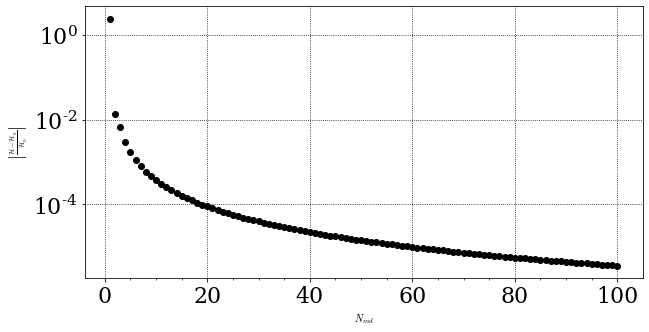

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

T=1
beta=1/T
N=15
J=1
h=1
#pretty plots
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def leap_frog(N_md, p_0, phi_0, J):
    epsilon = 1/N_md
    p, phi = p_0, phi_0
    #first leap-frog step
    phi = phi+epsilon/2*p
    for i in range(0,N_md-1):
        p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
        phi=phi+epsilon*p
    #last step of leap-frog
    p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
    phi=phi+epsilon/2*p
    return p, phi

def art_hamiltonian(p, phi,J, N):
    return p**2/2+phi**2/(2*beta*J)-N*np.log(2*np.cosh(beta*h+phi))

p_0=1
phi_0=1
hamiltonian_0=art_hamiltonian(p_0,phi_0,J/N ,N)
hamiltonian=[]
for i in range(1,101):
    p, phi = leap_frog(i,p_0,phi_0, J/N)
    hamiltonian.append(np.abs((art_hamiltonian(p,phi,J/N,N)-hamiltonian_0)/hamiltonian_0))
beauty_plot()
plt.plot(np.linspace(1,100,100),hamiltonian,'o',c="black")    
plt.yscale("log")    
plt.xlabel("$N_{md}$")
plt.ylabel("$\\left|\\frac{\\mathcal{H}-\\mathcal{H}_0}{\\mathcal{H}_0}\\right|$")
plt.show()

### Implementing HMC 

In [2]:
nTrajs = 4000
N_md = 50
N = 15
h=.5
nBS=100

def bootstrap_error(s, nBS): 
    n=len(s)
    bsmean = np.array([])
    for bs in range(nBS):
        index = np.random.randint(n, size=n)
        bsmean = np.append(bsmean, np.array([s[index[i]] for i in range(n)]).mean())
    return bsmean.std()



def numerical(J):
    phi_list = [1]
    m_observe = []
    energy_observe = []
    for traj in range(nTrajs):
        p_0 = np.random.normal(0,1)
        phi_0 = phi_list[-1]
        hamiltonian_0 = art_hamiltonian(p_0, phi_0, J/N, N)
        # Calculate p' and phi'
        p, phi = leap_frog(N_md,p_0,phi_0, J/N)
        hamiltonian = art_hamiltonian(p, phi, J/N, N)
        if np.random.uniform(0,1)<=np.exp(-beta*(hamiltonian-hamiltonian_0)):
            phi_list.append(phi)
        else:
            phi_list.append(phi_0)
    # Measurements
    m = []
    e=[]
    for phi in phi_list:
        m.append(np.tanh(beta*h+phi))
        e.append(-1/N*(phi*phi/(2*beta*beta*J/N)+h*N*np.tanh(beta*h+phi)-1/(2*beta)))
    
    return np.mean(m), np.mean(e), bootstrap_error(m, nBS), bootstrap_error(e, nBS)


### Analytical approach


In [3]:
def f_func(x,J,N):
    return np.exp(1/2*beta*J/N*x**2+beta*h*x)

def Z_func(J, N):
    f_sum = 0
    N_list = np.linspace(0, N, N+1)
    for n in N_list:
        f_sum += sc.binom(N, n)*f_func(N-2*n,J, N)
    return f_sum

def m_analytical(J, N):
    m_sum = 0
    N_list = np.linspace(0, N, N+1)
    for n in N_list:
        m_sum += sc.binom(N, n)* f_func(N-2*n, J, N)*(N-2*n)
    return 1/(N*Z_func(J, N))*m_sum
def energy_analytical(J,N):
    e_sum=0
    N_list=np.linspace(0,N,N+1)
    for n in N_list:
        e_sum+=sc.binom(N,n)*(0.5*beta*J/N*(N-2*n)**2+beta*h*(N-2*n))*f_func(N-2*n,J,N)
    return -1/(N*Z_func(J, N))*e_sum
    

In [ ]:
N_list = np.array([5,10, 15, 20])
J_list = np.array(np.linspace(0.2,2,15))


m_observed = []
m_error = []
energy_observed = []
energy_error = []

count = 0
for N in N_list:
    m_observed.append([])
    m_error.append([])
    energy_observed.append([])
    energy_error.append([])
    for J in J_list:
        m, e, error_m, error_e = numerical(J)
        m_observed[count].append(m)
        energy_observed[count].append(e)
        m_error[count].append(error_m)
        energy_error[count].append(error_e)
    count += 1


In [ ]:
beauty_plot()
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(N_list)+1)]
for i in range(len(m_observed)):
    plt.errorbar(x=J_list, y=m_observed[i],yerr=m_error[i],marker='.',color=colors[i],linestyle="None", label = "$N=$%d"%(N_list[i]))
    plt.plot(J_list, m_analytical(J_list, N_list[i]), color=colors[i],)
plt.xlabel("$J$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()


In [ ]:
beauty_plot()
for i in range(len(energy_observed)):
    plt.errorbar(x=J_list, y=energy_observed[i],yerr=energy_error[i],color=colors[i],marker='.',linestyle="None", label = "$N=$%d"%(N_list[i]))
    plt.plot(J_list, energy_analytical(J_list, N_list[i]),color=colors[i])
plt.xlabel("$J$")
plt.ylabel("$\\langle \\beta\\varepsilon \\rangle$")
plt.legend()
plt.show()
